25.01.2021

Image Processing in Physics, TUM
Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiß

# Exercise 1: Grating interferometry

In this exercise, we will process and analyze a dataset from
an X-ray grating interferometry setup.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

The following function just ensures that differential phase values
are mapped to the range $[-\pi, \pi]$:

In [10]:
def wrap_phase(inarray):
    outarray = np.angle(np.exp(1j * inarray))
    return outarray

## Step 1: Loading the data

Find path to the imaging data:

In [11]:
path = 'data'  # Relative path to the data
num_imgs = 11  # Number of stepping images

**"Format strings"** are string objects with placeholders that are filled out later.

This is often useful for managing measurement data
that is distributed over lots of small files, as in our case.

The placeholders are highlighted by a percent symbol:

`%s` is a placeholder for a string,
`%d` is a placeholder for an integer,
`%f` is for a floating point number, etc.

Values are filled in to the format string with the notation
`formatstring % value`. See some examples below.

There is also a more modern version for format strings in Python,
see e.g. https://docs.python.org/3/library/stdtypes.html#str.format

In [12]:
print("Integer: %d, float: %f" % (1.2, 3.4))
print("A string: %s." % "Hello")
print("normal float: %f, fewer digits: %.2f" % (np.pi, np.pi))
print("Exponential values: %.2e, zero-padded integer: %05d" % (np.e**3, 123))
print("Modern format strings: {}, {}, {}".format("one", 2, "three"))

Integer: 1, float: 3.400000
A string: Hello.
normal float: 3.141593, fewer digits: 3.14
Exponential values: 2.01e+01, zero-padded integer: 00123
Modern format strings: one, 2, three


We use a format string as a template for our filenames:

In [13]:
file_pattern = '%s_stepping_%04d.npy'

Now read in the raw data. There are two series of 11 `.npy` files each:

1. The stepping images **with** sample in the beam
   (`data_stepping_0000.npy` to `data_stepping_0010.npy`), and
2. The stepping images **without** sample, i.e. the flatfields
   (`flat_stepping_0000.npy` to `flat_stepping_0010.npy`).
   
You should read them in one after the other and combine them into two 3D `numpy` 
arrays with shape `(11, 195, 487)`. The zero-th dimension represents the stepping
images, the other two the actual dimensions of each image.

Use `np.load()` to read the data from each file.

In [14]:
imglist = []
flatlist = []
for i in range(num_imgs):
    # Load the image and flatfield from the current working directory
    path_data = os.path.join(os.getcwd(), path, file_pattern % ('data', i))
    img = np.load(path_data)
    imglist.append(img)
    path_flat = os.path.join(os.getcwd(), path, file_pattern % ('flat', i))
    flat = np.load(path_flat)
    flatlist.append(flat)

imgarr = np.array(imglist)
flatarr = np.array(flatlist)

To get a sense of what we just loaded into memory, we'll have a look at it.
`matplotlib` is not great for looking at 3D arrays. Instead, we'll use `pyqtgraph`.
Use the small yellow handle at the bottom of the screen to scroll through the images!

(If you can't get it installed, looking at individual
frames with plt.imshow() works too, of course.)

In case pyqtgraph only shows a black window, try to add `%gui qt` in the beginning of the following block:

In [15]:
%gui qt
import pyqtgraph as pg


pg.image(imgarr.swapaxes(1,2), title='Sample stepping')
pg.image(flatarr.swapaxes(1,2), title='Flatfield stepping')

ModuleNotFoundError: No module named 'pyqtgraph'

In [16]:
imgarr.shape

(11, 195, 487)

Plot the stepping curve of pixel `(50, 185)` of **both** data arrays.
You should see two (approximately) sinusoidal curves.

(11,)


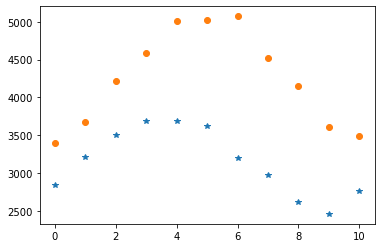

In [64]:
stepping_curve = imgarr[:, 50, 185]
ref_curve = flatarr[:, 50, 185]

plt.figure(1)
plt.clf()
plt.plot(stepping_curve, '*')  # plot a star for each data point
plt.plot(ref_curve, 'o')  # plot circles for each data point
print(ref_curve.shape)

## Step 2:  Perform a fit of a sinusoidal curve.

First, calculate the 1D FFT of `ref_curve`:

In [65]:
ft_ref_curve = np.fft.fft(ref_curve)
ft_stepping_curve = np.fft.fft(stepping_curve)
print(ft_ref_curve.shape)

(11,)


We are interested only in the 0-th and first element of the FFT: transmission and scattering/dark-field

In [39]:
f0, f1 = ft_ref_curve[0:2]
f_0, f_1 = ft_stepping_curve[0:2]

Note that the 0th Fourier component is always real-valued.

In [40]:
print('Im(f0):', f0.imag)
f0 = f0.real

Im(f0): 0.0


`f0` is the sum of all values of `ref_curve`. How do we get the mean value from that?

In [42]:
mean_value = f0/num_imgs
mean_value_stepping = f_0/num_imgs


The amplitude of the sinusoidal curve is given by the magnitude of `f1`
multiplied by `2. / num_imgs`, and the phase shift is the angle of `f1`:

In [43]:
amplitude = 2*np.abs(f1)/num_imgs
phase_shift = np.angle(f1)

amplitude_stepping = 2*np.abs(f_1)/num_imgs
phase_shift_stepping = np.angle(f_1)

The sinusoidal curve is fully described by these three parameters (`x` is the position on this curve):

In [44]:
def sine_curve(x, mean, amp, phase):
    return mean + amp * np.cos(x + phase)

We can then plot the sinusoidal fit:
We use a finer grid of x values in the plot to get a smooth curve.

Note that we have to rescale the x axis to align it with the measurement data:

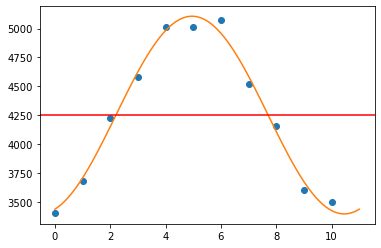

In [47]:
plt.figure()
plt.plot(ref_curve, 'o')
x = np.linspace(0, 2*np.pi, 100)
plt.plot(x * num_imgs / (2 * np.pi), sine_curve(x, mean_value, amplitude, phase_shift))
plt.axhline(y=mean_value, color='r', linestyle='-')


The interferometric visibility is given by the **ratio of amplitude and mean value**, and is typically expressed as a percentage (between 0 and 100%).

In [48]:
vis = amplitude/mean_value
print('Visibility: %.1f %%' % (100*vis))

Visibility: 20.1 %


**Bonus task**: Complete the same thing for the other sinusoidal curve `stepping_curve`, and combine data points and sinusoidal fits in the same figure!

/Users/Vania/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


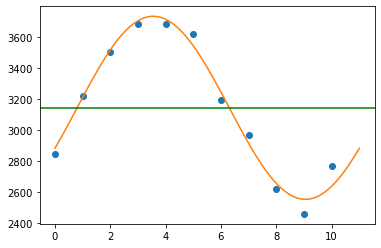

In [49]:


plt.figure()
plt.plot(stepping_curve, 'o')
x = np.linspace(0, 2*np.pi, 100)
plt.plot(x * num_imgs / (2 * np.pi), sine_curve(x, mean_value_stepping, amplitude_stepping, phase_shift_stepping))
plt.axhline(y=mean_value_stepping, color='g', linestyle='-')

## Part 3: Do the same thing, but for the entire set of images at once!

In part 2, we looked at a single detector pixel.
We now want to repeat the procedure for the entire detector.

As before, we start with a Fourier transform, albeit using the entire arrays `imgarr` and `flatarr`.
Note that we want to do **1-dimensional FFT**, separately for each pixel, along the axis 0.
Use the keyword `axis=0` for that purpose!

In [55]:
data_fft = np.fft.fft(imgarr, axis=0)   
flat_fft = np.fft.fft(flatarr, axis=0) 


Again, we require only the zero-th and first element (albeit now, for each pixel!)

In [56]:
d0, d1 = data_fft[0], data_fft[1]
f0, f1 = flat_fft[0], flat_fft[1]

d0 = d0.real
f0 = f0.real

As before, the mean value is the zero-th Fourier component, divided by `num_imgs`:

In [66]:
mean_data = d0/num_imgs #for every pixel there is a value
mean_flat = f0/num_imgs

The amplitude is the magnitude of the 1st Fourier component multiplied by `2 / num_imgs`:

In [67]:
amp_data = np.abs(d1)*2./num_imgs
amp_flat = np.abs(f1)*2./num_imgs

The phase shift is the angle of the 1st Fourier component:

In [68]:
phi_data = np.angle(d1)
phi_flat = np.angle(f1)

Now we can calculate the flatfield-corrected image modalities!

The transmittance is the ratio of `mean_data` and `mean_flat`:

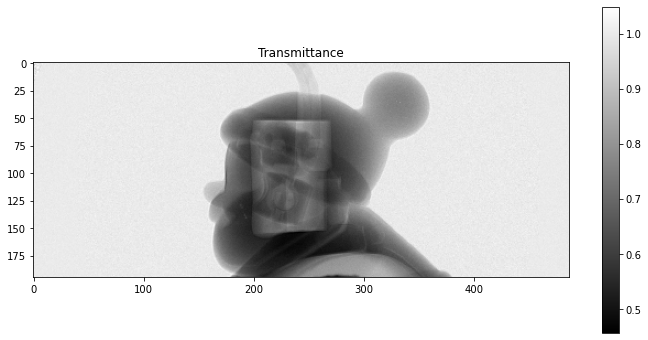

In [60]:
transmittance = mean_data/mean_flat

plt.figure(figsize=(12,6)); plt.title('Transmittance')
plt.imshow(transmittance, cmap='gray'); plt.colorbar()

As before, the visibility is the ratio of amplitude and mean value...

In [69]:
vis_data = amp_data / mean_data
vis_flat = amp_flat / mean_flat

... and the visibility reduction image is the ratio of `vis_data` and `vis_flat`:

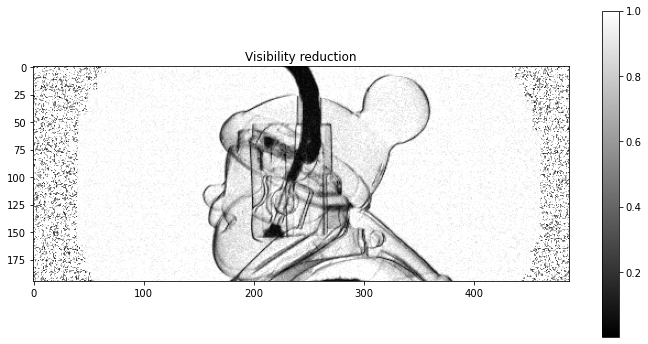

In [70]:
visred = vis_data / vis_flat

plt.figure(figsize=(12,6)); plt.title('Visibility reduction')
plt.imshow(visred, cmap='gray', vmax=1); plt.colorbar()

Note that the image looks terrible at the left and right edges.
This is because that region is not covered by the gratings, and the
amplitude of the stepping curve is zero in both datasets.

And finally, differential phase shift is given by the
difference (not the quotient!) of `phi_data` and `phi_flat`.

We use the function `wrap_phase()` defined above to map all phase values
to the range $[-\pi, \pi]$.

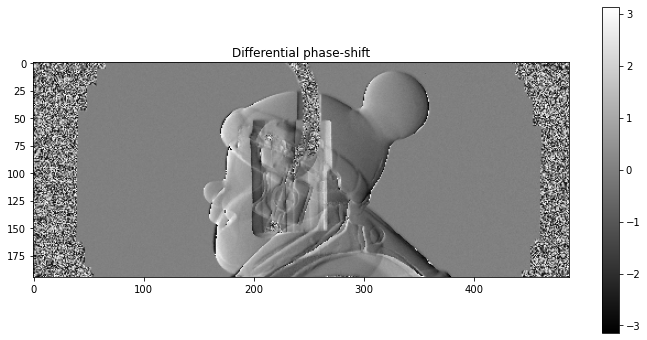

In [71]:
diff_phase = phi_data - phi_flat
diff_phase = wrap_phase(diff_phase)

plt.figure(figsize=(12,6)); plt.title('Differential phase-shift')
plt.imshow(diff_phase, cmap='gray'); plt.colorbar()

This figure is essentially a map of X-ray refraction angles due to the sample!